In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def dataset(size =  200, timesteps = 25):
    x, y = [], []
    sin_wave = np.sin(np.arange(size))
    for step in range(sin_wave.shape[0]-timesteps):
        x.append(sin_wave[step:step+timesteps])
        y.append(sin_wave[step+timesteps])
    return np.array(x).reshape(len(y),timesteps,1)[:,:,0],np.array(y).reshape(len(y),1)[:,0]

x,y = dataset()

x_test, y_test = dataset(300)
x_test = x_test[250:]
y_test = y_test[250:]

x.shape, y.shape, x_test.shape, y_test.shape

((175, 25), (175,), (25, 25), (25,))

100%|██████████| 50/50 [00:52<00:00,  1.04s/it]


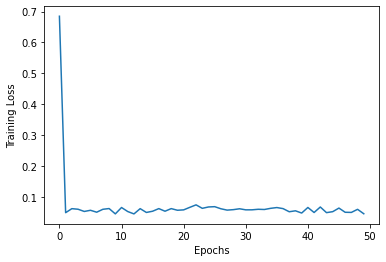

Test Loss= 0.30231693555399936


In [3]:
class RNN:
    def __init__(self, x, y, hidden_units):
        self.x = x # shape [samples, timesteps, features]
        self.y = y # shape [samples, outputs]
        self.hidden_units = hidden_units
        self.Wx = np.random.randn(hidden_units,x.shape[1]) # shape (hidden units, number of input features)
        self.Wh = np.random.randn(hidden_units,hidden_units) # shape (hidden units, hidden units)
        self.Wy = np.random.randn(1,hidden_units) # shape ( number of output features,hidden units)
        
    def cell(self, xt, ht_1):
        ht = np.tanh( self.Wx*xt + np.matmul(self.Wh,ht_1))
        yt = np.matmul(self.Wy,ht)
        return ht, yt
        
    def forward(self, sample):
        sample_x, sample_y = self.x[sample], self.y[sample]
        temp = self.Wx*sample_x
        self.ht = np.zeros(temp.shape) # first hidden state is zeros vector
        self.hidden_states = [self.ht] # collection of hidden states for each sample
        self.inputs = [] # collection of inputs for each sample
        for step in range(len(sample_x)):
            self.ht, yt = RNN.cell(self, sample_x[step],self.ht) # call cell definition to give ht, yt
            self.inputs.append(sample_x[step].reshape(1,1))
            self.hidden_states.append(self.ht) # use append to store all ht inside hidden_states 
        self.error = yt - sample_y # error = yt - true value of y
        self.loss = 0.5*(self.error)**2
        self.yt = yt

    def backward(self):
        n = 15 # number of terms present
        dyt = self.error # dL/dyt
        dWy = np.matmul(self.error,self.ht.T) # dL/dWy
        dht = dyt*self.Wx # dL/dht = dL/dyt * dyt/dht ,where ht = tanh(Wx*xt + Wh*ht))
        dWx = np.zeros(shape=(self.hidden_units,self.x.shape[1])) # inialise zeros of shape dWx
        dWh = np.zeros(shape=(self.hidden_units,self.hidden_units)) # inialise zeros of shape dWy
        # BPTT
        for step in reversed(range(n)):
            temp = dht*(1-self.ht[step]**2) # dL/dtanh = dL/dyt * dyt/dht * dht/dtanh, where dtanh = (1-ht**2) 
            dWx += temp*self.x[step] # dL/dWx = dL/dyt * dyt/dht * dht/dtanh * dtanh/dWx
            dWh += np.matmul(temp,self.ht.T) # dL/dWh = dL/dyt * dyt/dht * dht/dtanh * dtanh/dWh
            dht = dht[step]*(1-self.ht[step+1]**2) # dL/dht-1 = dL/dht * (1 - ht+1^2) * Whh   # updation of dht 
        
        dWy = np.clip(dWy, -1, 1)
        dWx = np.clip(dWx, -1, 1)
        dWh = np.clip(dWh, -1, 1)
        self.Wy -= self.lr * dWy
        self.Wx -= self.lr * dWx
        self.Wh -= self.lr * dWh
        
    def train(self, epochs, learning_rate):
        self.Ovr_loss = []
        self.print_loss = []
        self.lr = learning_rate
        for epoch in tqdm(range(epochs)):
            for sample in range(self.x.shape[0]):
                self.forward(sample)
                self.backward()
            self.Ovr_loss.append(np.squeeze(self.loss / self.x.shape[0]))
            self.print_loss.append(np.sum(np.squeeze(self.loss / self.x.shape[0])))
            self.loss = 0
        plt.plot(self.print_loss)
        plt.xlabel("Epochs")
        plt.ylabel("Training Loss")
        plt.show()
            
        
    def test(self,x,y):
        self.x = x
        self.y = y
        self.outputs = []
        for sample in range(len(x)):
            self.forward(sample)
            self.outputs.append(self.yt)
        print("Test Loss=",np.mean(0.5*(self.outputs - y)**2))
        
        

rnn = RNN(x,y,100)
rnn.train(50,1e-2)
rnn.test(x_test, y_test)